In [1]:
%load_ext autoreload
%autoreload 2
import HammingCode
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc
import NeuralNetworkCorrection as network
import Autoencoder
import math
import Utils

2024-06-03 13:04:35.715638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 13:04:35.715729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 13:04:35.718027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 13:04:35.732516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 13:04:37.128643: W tensorflow/compiler/tf2

In [2]:
variancia = 1
code_rate = 4/7
# amostra
Eb_dB_values = np.arange(3, 16, 1)

# Gerar dados de treinamento
training_sample_length = 10 ** 3
epoches = 100
batch_size = 32

In [4]:
training_data = {
    'original': [],
    'noisy': [],
    'info': []
}

training_information = network.get_training_data_set(training_sample_length)

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(training_information, eb_db, variancia)
    training_data['noisy'].extend(info['split_noisy_original_data_15_11'])
    training_data['original'].extend(info['split_original_data_15_11'])

training_data['noisy'] = np.array(training_data['noisy'])
training_data['original'] = np.array(training_data['original'])

In [5]:
# Criar e treinar a rede neural
model = network.train_neural_network(training_data, epoches, batch_size)

[[0 1 1 ... 1 0 1]
 [1 0 1 ... 1 1 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 1 1 ... 0 1 1]
 [1 0 1 ... 1 1 0]
 [1 1 1 ... 0 0 0]]
Epoch 1/100
34/34 [==============================] - 2s 14ms/step - loss: 0.4650 - accuracy: 0.0836 - val_loss: 0.1828 - val_accuracy: 0.1345 - lr: 0.0010
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0771 - accuracy: 0.1532 - val_loss: 0.0508 - val_accuracy: 0.2101 - lr: 0.0010
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0240 - accuracy: 0.2096 - val_loss: 0.0431 - val_accuracy: 0.2605 - lr: 0.0010
Epoch 4/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0193 - accuracy: 0.2011 - val_loss: 0.0442 - val_accuracy: 0.0756 - lr: 0.0010
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 0.1767 - val_loss: 0.0460 - val_accuracy: 0.2101 - lr: 0.0010
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 0.0151 - accuracy: 0.2058 - val_loss

In [6]:
autoencoder = Autoencoder.create_and_train_auto_encoder(training_data, epoches, batch_size)

Epoch 1/100
37/37 [==============================] - 2s 12ms/step - loss: 0.7069 - accuracy: 0.0025 - val_loss: 0.6902 - val_accuracy: 0.0101
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 0.6767 - accuracy: 0.0135 - val_loss: 0.6624 - val_accuracy: 0.0220
Epoch 3/100
37/37 [==============================] - 0s 7ms/step - loss: 0.6488 - accuracy: 0.0228 - val_loss: 0.6343 - val_accuracy: 0.0228
Epoch 4/100
37/37 [==============================] - 0s 7ms/step - loss: 0.6200 - accuracy: 0.0363 - val_loss: 0.6044 - val_accuracy: 0.0431
Epoch 5/100
37/37 [==============================] - 0s 5ms/step - loss: 0.5889 - accuracy: 0.0431 - val_loss: 0.5711 - val_accuracy: 0.0330
Epoch 6/100
37/37 [==============================] - 0s 6ms/step - loss: 0.5522 - accuracy: 0.0440 - val_loss: 0.5307 - val_accuracy: 0.0549
Epoch 7/100
37/37 [==============================] - 0s 6ms/step - loss: 0.5109 - accuracy: 0.0609 - val_loss: 0.4893 - val_accuracy: 0.0676
Epoch 8/100


In [49]:
# Gerar dados de teste
amostras_ruidosas = []
amostras_originais = []
ML_result = []
tradicional_result = []
autoencoder_result = []


In [50]:
test_data = {
    'original': [],
    'info': []
}
test_sample_length = 10 ** 6
test_information = network.get_training_data_set(test_sample_length)

total_chunks = math.floor(test_sample_length / 11)
total_length_chunks = total_chunks * 11
smaller_array_len = test_sample_length - total_length_chunks

adjustment_test = 11 - smaller_array_len

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(test_information, eb_db, variancia)
    test_data['info'].append(info)
    test_data['original'] = info['original_data']

In [52]:
print(len(test_data['info'][0]['split_noisy_original_data_15_11']))

9091


In [53]:
i = 0
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))

100001


In [56]:
i = 1
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))

In [57]:
i = 2
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))

In [58]:
i = 3
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [59]:
i = 4
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [60]:
i = 5
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))

In [61]:
i = 6
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [62]:
i = 7
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [63]:
i = 8
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [64]:
i = 9
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [65]:
i = 10
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [66]:
i = 11
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [67]:
i = 12
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_noisy_original_data_15_11'], model))


In [68]:
for i in test_data['info']:
   tradicional_result.append(HammingCode.decode_sample(i['split_encoded_data']))

In [69]:
BER_tradicional = []
BER_autoencoder = []
BER_ML = []
paddded_array = test_data['info'][0]['padded_array_original_data']
for i in range(0, len(autoencoder_result)):
    BER_ML.append(np.sum(np.array(ML_result[i]).astype(int) != paddded_array) / len(paddded_array))
    BER_tradicional.append(np.sum(np.array(tradicional_result[i]).astype(int) != test_data['original']) / len(test_data['original']))
    BER_autoencoder.append(np.sum(np.array(autoencoder_result[i]).astype(int) != paddded_array) / len(paddded_array))

# Calcular a BER teórica
Eb_coded = np.array([eb_db + 10*np.log10(code_rate) for eb_db in Eb_dB_values])
Eb_values = 10**(Eb_coded/10)
BER_teorica = 0.5 * erfc(np.sqrt(Eb_values))

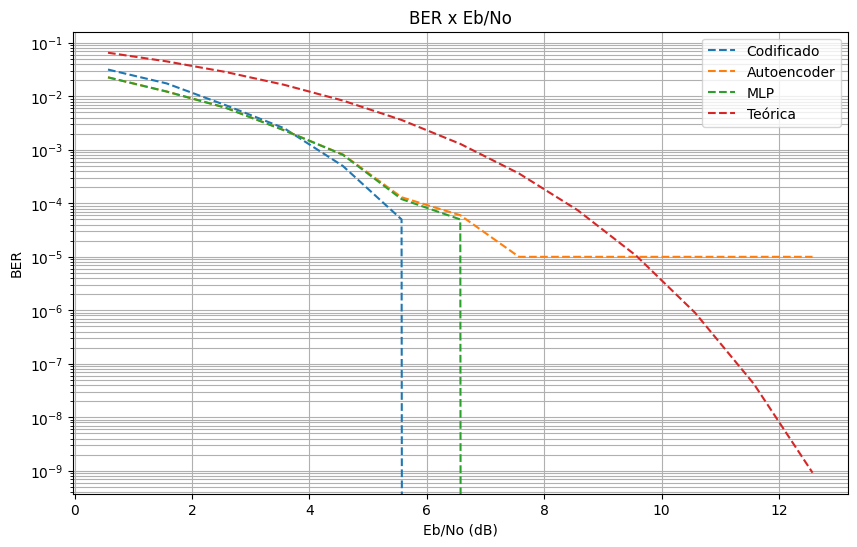

In [70]:
# Plotar as taxas de erro de bit simuladas e teóricas
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_coded, BER_tradicional, linestyle = '--', label='Codificado')
plt.semilogy(Eb_coded, BER_autoencoder, linestyle = '--', label='Autoencoder')
plt.semilogy(Eb_coded, BER_ML, linestyle = '--', label='MLP')
plt.semilogy(Eb_coded, BER_teorica, linestyle='--', label='Teórica')
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.grid(True, which='both')
plt.legend()
plt.title('BER x Eb/No')
plt.show()